In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("netflix.csv")
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


## A. Data Cleaning

In [4]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [5]:
df.duplicated().sum()

0

### 1. Removing columns with more than 1 NaN value

In [7]:
df = df[~(df.isna().sum(axis=1) > 1)]

In [8]:
df.isna().sum()

show_id            0
type               0
title              0
director        1958
cast             415
country          364
date_added         0
release_year       0
rating             1
duration           3
listed_in          0
description        0
dtype: int64

### 2. Labeling NaN values in the "rating" column as "NR"

In [10]:
df["rating"] = df["rating"].fillna("NR")

### 3. Removing NaN values in the "country" column

In [12]:
df = df[~(df["country"].isna())]

### 4. Labeling NaN values in the "cast" and "director" columns as "Unknown"

In [14]:
df[["cast", "director"]] = df[["cast", "director"]].fillna("Unknown")

### 5. Removing NaN values in the "duration" column

In [16]:
df = df[~(df["duration"].isna())]

In [17]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

### 6. Removing whitespace from all columns

In [19]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [20]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

## B. Data Preprocessing

### 1. Changing data type of the "date_added" column to datetime

In [23]:
df["date_added"] = pd.to_datetime(df["date_added"])

### 2. Categorizing the rating for better readibility

In [25]:
rating = set(df["rating"].unique())
rating

{'G',
 'NC-17',
 'NR',
 'PG',
 'PG-13',
 'R',
 'TV-14',
 'TV-G',
 'TV-MA',
 'TV-PG',
 'TV-Y',
 'TV-Y7',
 'TV-Y7-FV',
 'UR'}

In [26]:
rating_map = {
    'G': "General Audience",
    'NC-17': "Adult",
    'NR': "Not Rated",
    'PG': "Parental Guidance",
    'PG-13': "Parental Guidance",
    'R': "Adult",
    'TV-14': "Teen",
    'TV-G': "General Audience",
    'TV-MA': "Adult",
    'TV-PG': "Parental Guidance",
    'TV-Y': "Kids",
    'TV-Y7': "Kids",
    'TV-Y7-FV': "Parental Guidance",
    'UR': "Not Rated"
}

df["rating"] = df["rating"].map(rating_map)

### 3. Simplify genres by categorizing them

In [28]:
genre_map = {
    "Action & Adventure": ["TV Action & Adventure", "Action & Adventure"],
    "Anime": ["Anime Features", "Anime Series"],
    "Children & Family": ["Children & Family Movies", "Kids' TV"],
    "Classic & Cult": ["Classic Movies", "Cult Movies", "Classic & Cult TV"],
    "Comedy": ["TV Comedies", "Comedies", "Stand-Up Comedy & Talk Shows", "Stand-Up Comedy"],
    "Crime": ["Crime Movies", "Crime TV Shows"],
    "Documentary": ["Documentaries", "Docuseries", "Science & Nature TV"],
    "Drama": ["TV Dramas", "Dramas"],
    "Horror": ["Horror Movies", "TV Horror"],
    "Independent": ["Independent Movies"],
    "International": ["International Movies", "International TV Shows"],
    "LGBTQ": ["LGBTQ Movies"],
    "Music": ["Music & Musicals"],
    "Reality": ["Reality TV"],
    "Romance": ["Romantic Movies", "Romantic TV Shows"],
    "Sci-Fi & Fantasy": ["TV Sci-Fi & Fantasy"],
    "Spanish-Language": ["Spanish-Language TV Shows"],
    "Sports": ["Sports Movies"],
    "Teen": ["Teen TV Shows"],
    "Thriller": ["TV Thrillers", "Thrillers", "TV Mysteries"]
}

for key, values in genre_map.items():
    for value in values:
        df["listed_in"] = df["listed_in"].str.replace(value, key)

### 4. Checking the value of the "duration" column

**If TV Show does not contain the word "season"**

In [31]:
df[(df["type"] == "TV Show") & (~(df["duration"].str.contains("season", case=False)))]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


**If Movies does not contain the word "min"**

In [33]:
df[(df["type"] == "Movie") & (~(df["duration"].str.contains("min", case=False)))]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


### 5. Changing data type of the "duration" column to integer

In [35]:
df["duration"] = df["duration"].str.replace("seasons|season|min", "", regex=True, case=False)
df["duration"] = df["duration"].str.strip()
df["duration"] = pd.to_numeric(df["duration"])

### 6. Extracting the month from the "date_added" column

In [37]:
df["month_added"] = df["date_added"].dt.month_name()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

### 7. Counting the content types
**For plot (1)**

In [39]:
content_type_count = df["type"].value_counts().reset_index()

### 8.  Dividing the dataframe into 2 types: TV Show and Movie

In [41]:
# tv show
df_tvshow = df[df["type"] == "TV Show"].reset_index(drop=True)

# movie
df_movie =  df[df["type"] == "Movie"].reset_index(drop=True)

### 9. Counting countries
**For plot (2)**

It is known that **some TV shows or movies have more than 1 country of origin** (a co-production).

In [44]:
len(df[df["country"].str.split(", ").str.len() > 1])

1296

So we **split and count each one** for each country.

In [46]:
df_duplicate = df.copy()
df_duplicate["country"] = df_duplicate["country"].str.split(", ")
df_country = df_duplicate.explode("country")
df_country = df_country[["show_id", "type", "country"]]

In [47]:
# tv show
tvshow_country_count = df_country[df_country["type"] == "TV Show"]["country"].value_counts().reset_index()

# movie
movie_country_count = df_country[df_country["type"] == "Movie"]["country"].value_counts().reset_index()

### 10. Counting year
**For plot (3)**

In [49]:
year_count = df.groupby(["type", "release_year"]).size().reset_index()
year_count.columns = ["type", "release_year", "count"]

### 11. Counting the content rating
**For plot (4)**

In [51]:
# tv show
rating_tvshow_count = df_tvshow["rating"].value_counts().reset_index()
rating_tvshow_count.columns = ["rating", "count"]

# movie
rating_movie_count = df_movie["rating"].value_counts().reset_index()
rating_movie_count.columns = ["rating", "count"]

### 12. Categorizing by genre
**For plot (5)**

In [53]:
# tv show
df_genre_tvshow = df_tvshow["listed_in"].str.get_dummies(sep=", ")
genre_tvshow_count = df_genre_tvshow.sum().sort_values(ascending=False).reset_index()
genre_tvshow_count.columns = ["genre", "count"]

# movie
df_genre_movie = df_movie["listed_in"].str.get_dummies(sep=", ")
genre_movie_count = df_genre_movie.sum().sort_values(ascending=False).reset_index()
genre_movie_count.columns = ["genre", "count"]

## 3. Visualization

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

### (1) Distribution of Content Types

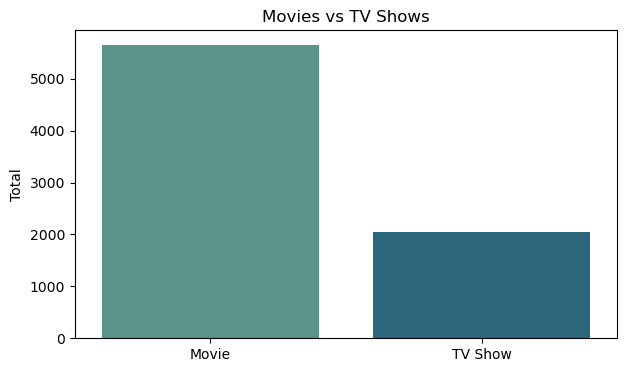

In [57]:
plt.figure(figsize=(7,4))
sns.barplot(x="type", y="count", data=content_type_count, hue="type", palette="crest")
plt.title("Movies vs TV Shows")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

The bar plot reveals a significant imbalance in the total count of movies and TV shows, with movies dominating the dataset at over 5000 entries compared to nearly 2000 TV shows. This indicates a stronger focus on movie distribution by Netflix over the years.
**But**, it is important to note that each TV show is counted as a single title regardless of its number of seasons, which can include multiple episodes, while a movie is counted individually.

### (2) Top 5 Country of Origin by Content

**TV Show**

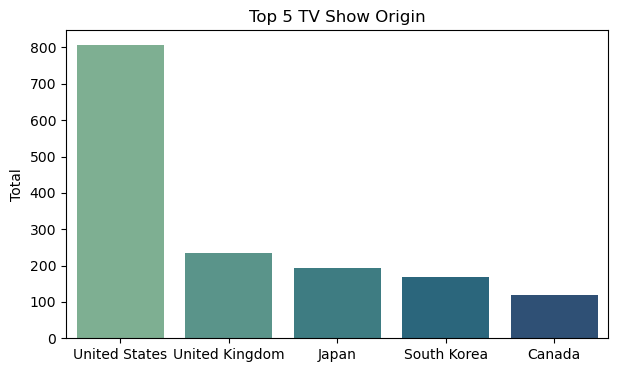

In [61]:
plt.figure(figsize=(7,4))
sns.barplot(x="country", y="count", data=tvshow_country_count.head(5), hue="country", palette="crest")
plt.title("Top 5 TV Show Origin")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

**Movie**

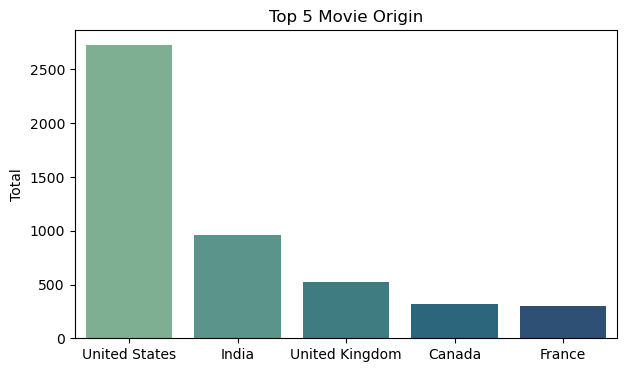

In [63]:
plt.figure(figsize=(7,4))
sns.barplot(x="country", y="count", data=movie_country_count.head(5), hue="country", palette="crest")
plt.title("Top 5 Movie Origin")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

The bar plots for TV shows and movies highlight the United States as the leading contributor in both categories. For TV shows, it surpasses 700 counts, followed by the UK, Japan, South Korea, and Canada. In movies, the U.S. accounts for almost 2,500, with India coming in second at nearly 1,000, and the UK, Canada, and France trailing behind.

### (3) Number of Releases Over Time

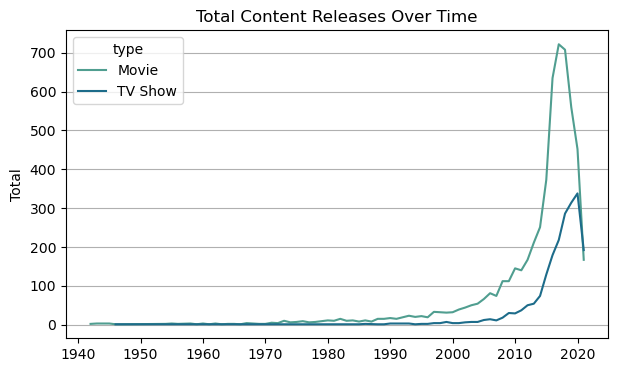

In [66]:
plt.figure(figsize=(7,4))
sns.lineplot(x="release_year", y="count", data=year_count, hue="type", palette="crest")
plt.title("Total Content Releases Over Time")
plt.xlabel("")
plt.ylabel("Total")
plt.grid(axis="y")
plt.show()

The line plot illustrates a notable trend in content releases from 1942 to 2020. Both movies and TV shows show a consistent increase, peaking in 2017 for movies and 2020 for TV shows, followed by a decline in subsequent years.

### (4) Distribution of Content Ratings

**TV Show**

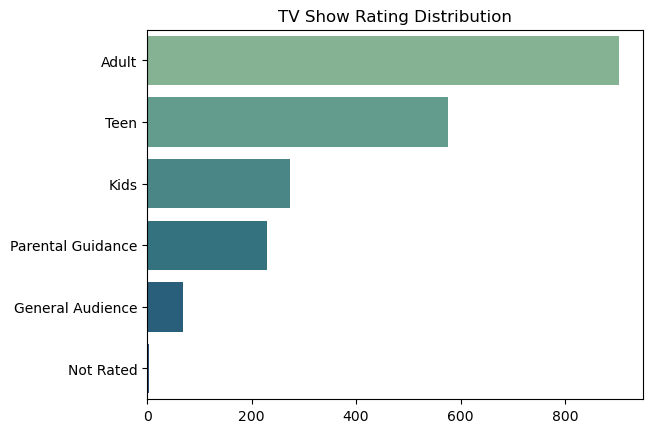

In [70]:
sns.barplot(x="count", y="rating", data=rating_tvshow_count, hue="rating", palette="crest")
plt.title("TV Show Rating Distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()

**Movie**

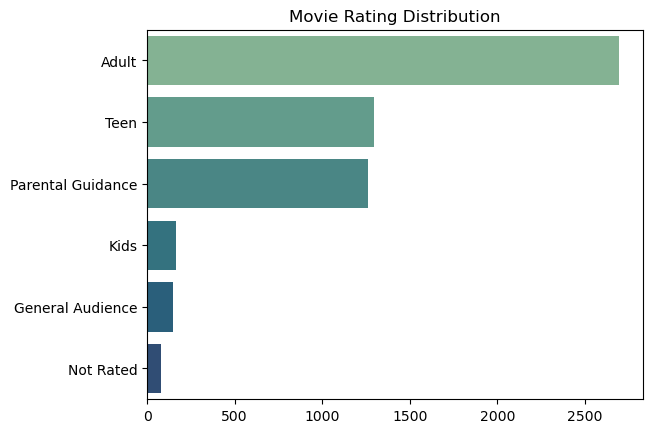

In [72]:
sns.barplot(x="count", y="rating", data=rating_movie_count, hue="rating", palette="crest")
plt.title("Movie Rating Distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()

The horizontal bar plots indicate a preference for adult-rated content in both TV shows (over 800) and movies (almost 2,500). Teen ratings also show significant representation, especially in movies, while other ratings like kids and general audience are less common.

### (5) Top 5 Genres by Frequency

**TV Show**

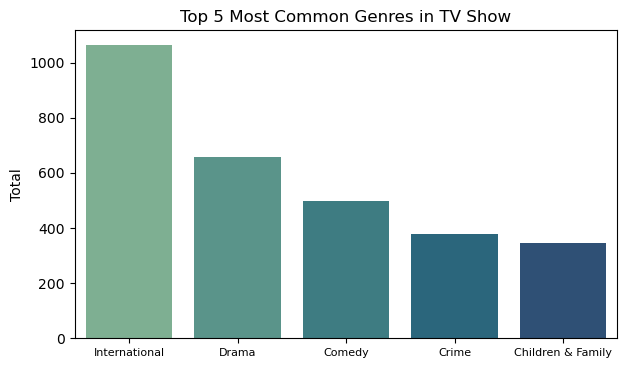

In [76]:
plt.figure(figsize=(7,4))
sns.barplot(x="genre", y="count", data=genre_tvshow_count.head(5), hue="genre", palette="crest")
plt.title("Top 5 Most Common Genres in TV Show")
plt.xlabel("")
plt.xticks(fontsize=8)
plt.ylabel("Total")
plt.show()

**Movie**

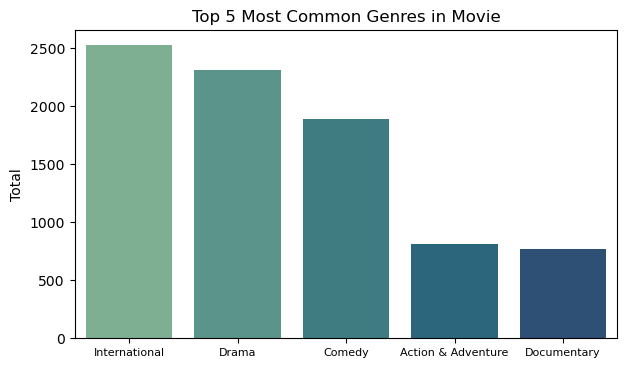

In [78]:
plt.figure(figsize=(7,4))
sns.barplot(x="genre", y="count", data=genre_movie_count.head(5), hue="genre", palette="crest")
plt.title("Top 5 Most Common Genres in Movie")
plt.xlabel("")
plt.xticks(fontsize=8)
plt.ylabel("Total")
plt.show()

The bar plot analysis indicates that "international TV shows" is the most frequent genre for TV content, nearing 1,000 counts, while "international movies" tops the movie genre count at around 2,500. Other genres like dramas and comedies also show strong representation in both categories.

### (6) Distribution of Durations

**TV Show**

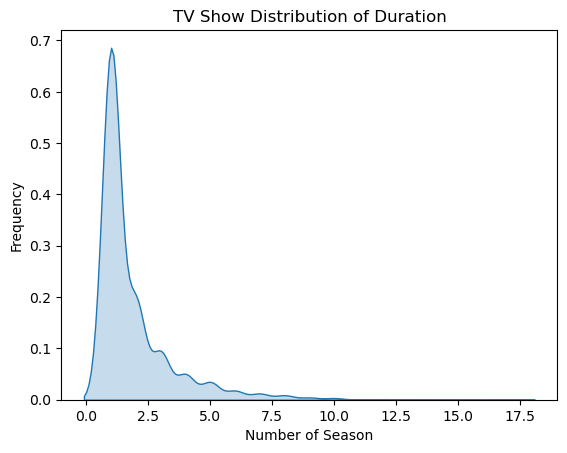

In [82]:
sns.kdeplot(df_tvshow["duration"], fill=True)
plt.title("TV Show Distribution of Duration")
plt.xlabel("Number of Season")
plt.ylabel("Frequency")
plt.show()

**Movie**

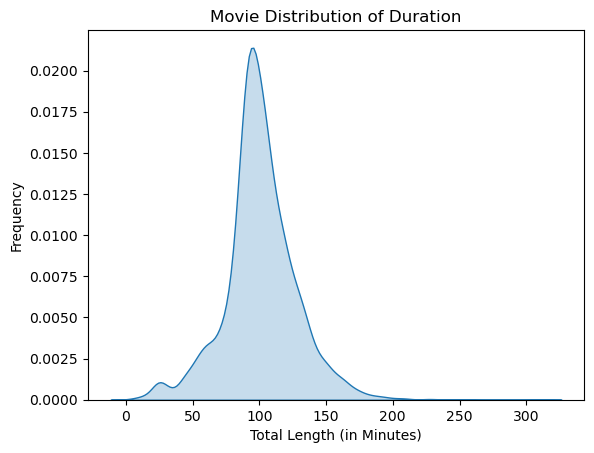

In [84]:
sns.kdeplot(df_movie["duration"], fill=True)
plt.title("Movie Distribution of Duration")
plt.xlabel("Total Length (in Minutes)")
plt.ylabel("Frequency")
plt.show()

The KDE plots suggest that TV shows typically last about 1.25 seasons, peaking in frequency, while movies tend to have an average duration of about 90 minutes.

### (7) In which month was content added the most?

**TV Show**

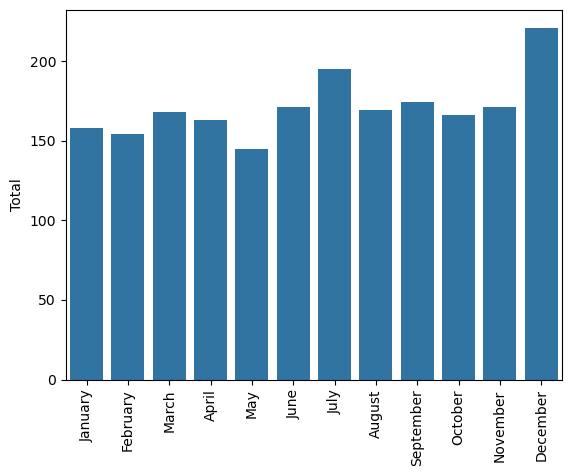

In [88]:
sns.countplot(x="month_added", data=df_tvshow, order=month_order)
plt.xlabel("")
plt.ylabel("Total")
plt.xticks(rotation=90)
plt.show()

**Movie**

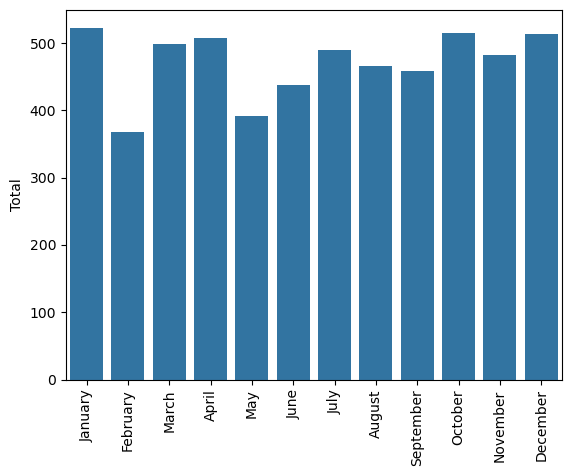

In [90]:
sns.countplot(x="month_added", data=df_movie, order=month_order)
plt.xlabel("")
plt.ylabel("Total")
plt.xticks(rotation=90)
plt.show()

The bar plots for monthly content additions reveal fluctuations, with both TV shows and movies peaking in the fourth quarter of the year. This trend may reflect seasonal viewing patterns and release strategies in the entertainment industry, particularly in January.

### 3.5. Helper

In [135]:
df.to_csv("netflix_clean.csv", index=False)

In [137]:
dummy = df["listed_in"].str.get_dummies(sep=", ")
dummy = dummy.map(lambda x: bool(x))
df_genre = pd.concat([df["show_id"], dummy], axis=1)

df_genre.to_csv("netflix_genre.csv", index=False)

In [138]:
df_country[["show_id", "country"]].to_csv("netflix_country.csv", index=False)

In [139]:
df_tvshow[["show_id", "duration"]].to_csv("netflix_tvshow_duration.csv", index=False)
df_movie[["show_id", "duration"]].to_csv("netflix_movie_duration.csv", index=False)

### 4. Dashboard

Making dashboard using *Tableau*

In [ ]:
import webbrowser

url = "https://public.tableau.com/app/profile/erich.dewantara/viz/ExploringNetflixContentTrendReports/Dashboard1"
webbrowser.open(url)